In [1]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
from scipy.interpolate import interp1d


file_path = '/Users/thomas/Desktop/phd_unipv/Industrial_PhD/Data/20241126/csv_acc/sample_17hr_26_11_2024.parquet'
df = pl.read_parquet(file_path)

df = df.to_pandas()

In [2]:

original_df = df

original_df.tail()


,time,03091002_x,03091003_x,03091005_x,03091006_x,03091007_x,03091008_x,0309100A_x,0309100B_z,0309100F_x,...,0309120A_z,0309120B_x,0309120C_x,0309120D_x,0309120E_x,0309120F_x,03091210_x,03091211_x,03091212_x,0309123B_z
359995,2024/11/26 17:59:59:950,1.022770,1.011376,1.005735,1.023164,1.011965,0.991427,1.024403,-1.013260,1.012120,...,-1.034371,1.015396,0.995906,1.000879,0.997128,1.007000,1.001180,1.033524,1.010782,-1.034977
359996,2024/11/26 17:59:59:960,1.022248,1.010893,1.005314,1.022992,1.011745,0.990965,1.024181,-1.012731,1.011811,...,-1.034133,1.014989,0.995828,1.000720,0.996921,1.006361,1.000972,1.033148,1.010625,-1.035217
359997,2024/11/26 17:59:59:970,1.022339,1.011000,1.005637,1.022929,1.012081,0.991197,1.023772,-1.012897,1.011891,...,-1.034390,1.014943,0.996065,1.000755,0.996823,1.006821,1.001112,1.033257,1.010821,-1.035301
359998,2024/11/26 17:59:59:980,1.022951,1.011451,1.006070,1.023528,1.012407,0.991962,1.024071,-1.013572,1.012340,...,-1.034838,1.015191,0.996387,1.001106,0.997431,1.006915,1.001505,1.033710,1.011037,-1.034962
359999,2024/11/26 17:59:59:990,1.022429,1.011165,1.005543,1.023121,1.011829,0.991481,1.024419,-1.013206,1.011971,...,-1.034378,1.015145,0.996007,1.000744,0.997233,1.007353,1.001267,1.033487,1.010620,-1.035150


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360000 entries, 0 to 359999
Columns: 107 entries, time to 0309123B_z
dtypes: float64(106), object(1)
memory usage: 293.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360000 entries, 0 to 359999
Columns: 107 entries, time to 0309123B_z
dtypes: datetime64[ns](1), float64(106)
memory usage: 293.9 MB


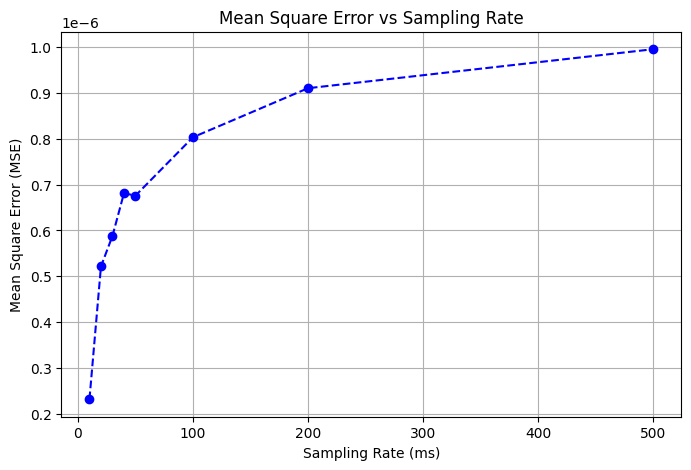

[np.float64(2.3182723733802667e-07), np.float64(5.214920015637224e-07), np.float64(5.880521320983831e-07), np.float64(6.812100052386921e-07), np.float64(6.760329410455007e-07), np.float64(8.033916911508416e-07), np.float64(9.103760650200023e-07), np.float64(9.954256602312933e-07)]
Sampling Rate: 10 ms, MSE: 0.00000023
Sampling Rate: 20 ms, MSE: 0.00000052
Sampling Rate: 30 ms, MSE: 0.00000059
Sampling Rate: 40 ms, MSE: 0.00000068
Sampling Rate: 50 ms, MSE: 0.00000068
Sampling Rate: 100 ms, MSE: 0.00000080
Sampling Rate: 200 ms, MSE: 0.00000091
Sampling Rate: 500 ms, MSE: 0.00000100


In [3]:

# Define sampling rates to test (in milliseconds)
sampling_rates_ms = [10, 20, 30, 40, 50, 100, 200, 500]  # Downsample to 20ms, 40ms, 60ms, and 100ms, 200ms, 500ms
mse_values = []

original_df.info()

original_df['time'] = pd.to_datetime(original_df['time'], format = '%Y/%m/%d %H:%M:%S:%f', errors="coerce", exact=False)

original_df.info()
# Interpolate the original signal for comparison
original_time = original_df['time'].astype(np.int64) // 10**6
original_values = original_df['03091002_x']

for rate_ms in sampling_rates_ms:
    # Downsample the signal
    downsampled_time = original_time.iloc[::rate_ms // 5].to_numpy()
    downsampled_values = original_values.iloc[::rate_ms // 5].to_numpy()
    #downsampled_values = original_values[::rate_ms // 5]

    # Interpolate the downsampled signal back to the original time resolution
    interpolator = interp1d(downsampled_time, downsampled_values, kind='cubic', fill_value="extrapolate")
    interpolated_values = interpolator(original_time)

    # Calculate Mean Square Error (MSE)
    mse = np.mean((original_values - interpolated_values) ** 2)
    mse_values.append(mse)

# Plot the MSE against sampling rates
plt.figure(figsize=(8, 5))
plt.plot(sampling_rates_ms, mse_values, marker='o', linestyle='--', color='b')
plt.title("Mean Square Error vs Sampling Rate")
plt.xlabel("Sampling Rate (ms)")
plt.ylabel("Mean Square Error (MSE)")
plt.grid()
plt.show()


print(mse_values)
# Print MSE values for reference
for rate, mse in zip(sampling_rates_ms, mse_values):
    print(f"Sampling Rate: {rate} ms, MSE: {mse:.8f}")

In [64]:
#If NMSE < 0.01 (1%), the error is typically considered low.
#	If NMSE > 0.1 (10%), the error is relatively high.

In [65]:
#SNR > 20 dB: High-quality reconstruction.
#SNR ~ 10 dB: Acceptable quality for many applications.
#SNR < 10 dB: Poor-quality reconstruction.

In [4]:
# **Signal-to-Noise Ratio (SNR) Calculation**
signal_power = np.mean(original_values**2)
snr_values = [10 * np.log10(signal_power / mse) for mse in mse_values]

# Print SNR values
for rate, snr in zip(sampling_rates_ms, snr_values):
    print(f"Sampling Rate: {rate} ms, SNR: {snr:.2f} dB") 

Sampling Rate: 10 ms, SNR: 66.54 dB
Sampling Rate: 20 ms, SNR: 63.02 dB
Sampling Rate: 30 ms, SNR: 62.50 dB
Sampling Rate: 40 ms, SNR: 61.86 dB
Sampling Rate: 50 ms, SNR: 61.89 dB
Sampling Rate: 100 ms, SNR: 61.14 dB
Sampling Rate: 200 ms, SNR: 60.60 dB
Sampling Rate: 500 ms, SNR: 60.21 dB


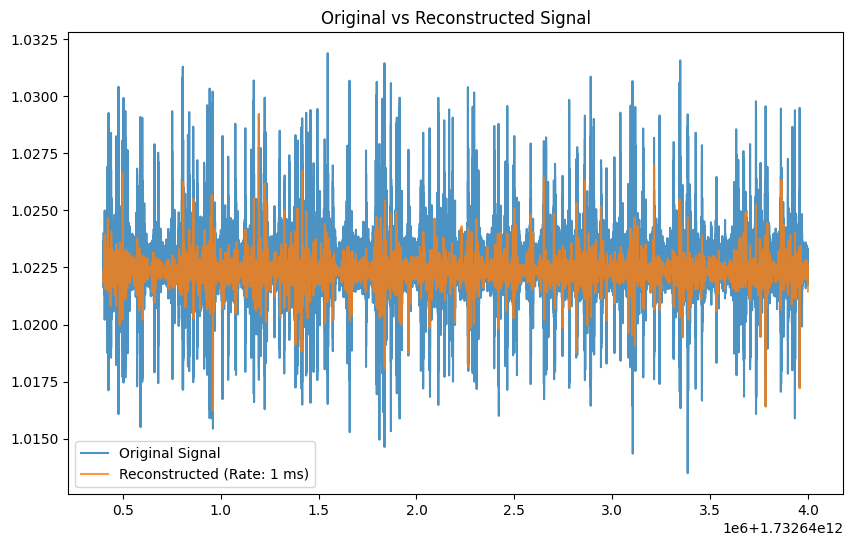

In [5]:
rate_to_visualize = 1 

plt.figure(figsize=(10, 6))
plt.plot(original_time, original_values, label='Original Signal', alpha=0.8)
plt.plot(original_time, interpolated_values, label=f'Reconstructed (Rate: {rate_to_visualize} ms)', alpha=0.8)
plt.title("Original vs Reconstructed Signal")
plt.legend()
plt.show()



In [51]:
from scipy.fft import fft, ifft



In [52]:
fft_result = fft(original_values.values)


/Users/thomas/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


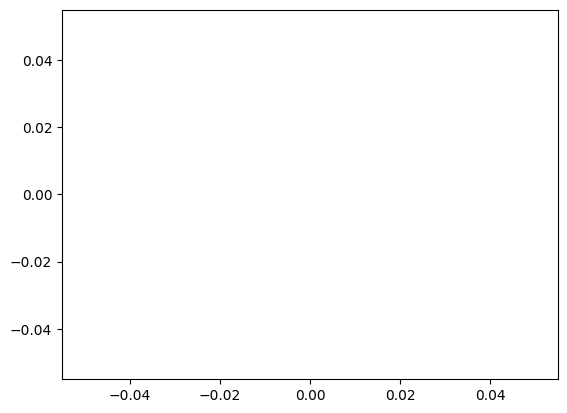

In [41]:
plt.plot(fft_result)

In [42]:

N = len(fft_result)
n = np.arange(N)
T = N/5
freq = n/T 

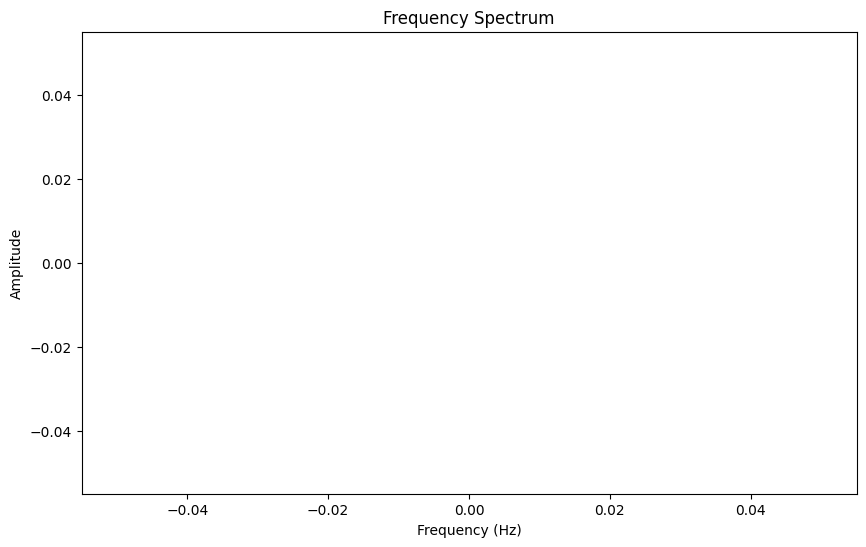

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(fft_result)
plt.title("Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()

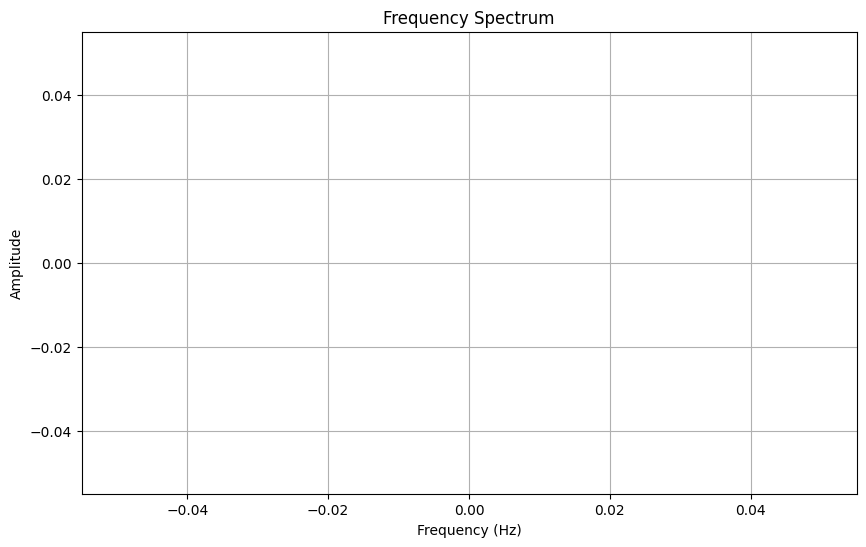

Mean Square Error (MSE): 1.015629


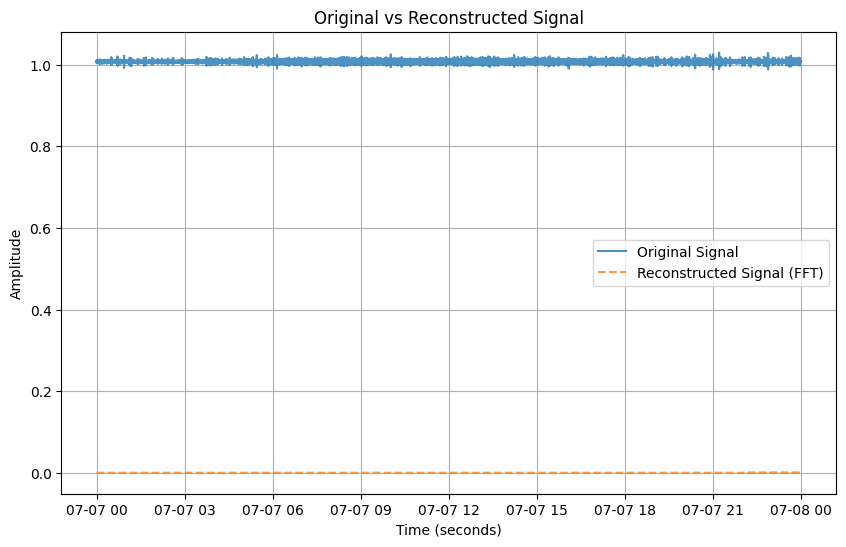

In [39]:
frequencies = np.fft.fftfreq(len(original_values), d=0.005)  # Frequency bins (sampling interval = 5ms)

# Visualize the FFT spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies[:len(frequencies) // 2], np.abs(fft_result)[:len(frequencies) // 2])
plt.title("Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")

plt.show()


# Perform Inverse FFT to reconstruct the signal
reconstructed_signal = ifft(frequencies).real

# Calculate MSE between original and reconstructed signal
mse = np.mean((original_values - reconstructed_signal) ** 2)
print(f"Mean Square Error (MSE): {mse:.6f}")

# Visualize the original and reconstructed signals
plt.figure(figsize=(10, 6))
plt.plot(original_time, original_values, label='Original Signal', alpha=0.8)
plt.plot(original_time, reconstructed_signal, label='Reconstructed Signal (FFT)', linestyle='--', alpha=0.8)
plt.title("Original vs Reconstructed Signal")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()